In [1]:
import networkx as nx
import pandas
from hatchet import *
import os
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import igraph
import platform

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/usr/local/lib/python3.6/dist-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
# libraries for gromov distance computation.
import numpy as np
import scipy as sp
import ot
from sklearn.decomposition import PCA
from sklearn import manifold
from grave import plot_network

In [3]:
from actions.groupBy import groupBy
from state import State
from callgraph import CallGraph
from preprocess import PreProcess
import diff_callflow_states as diff 

In [4]:
%matplotlib inline

In [5]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (16, 12)

In [6]:
dataset_path = ["data/lulesh-1/db-ampi4-100-1", "data/lulesh-1/db-ampi4-100-8"]
states = diff.main(dataset_path)

Creating graphframes....
0:/home/vidi/Work/llnl/CallFlow/data/lulesh-1/db-ampi4-100-1
1:/home/vidi/Work/llnl/CallFlow/data/lulesh-1/db-ampi4-100-8
Filtering the dataframe!
(185290, 10)
[Filter] Removed 184465 rows.)
Grafting the graph!
[Graft] 825 rows left
Filtering the dataframe!
(300890, 10)
[Filter] Removed 300045 rows.)
Grafting the graph!
[Graft] 845 rows left
Shape of the dataframe from graph (data): (825, 10)
Total nodes in the graph 114
3.5189149379730225
Shape of the dataframe from graph (data): (845, 10)
Total nodes in the graph 96
2.896909236907959


In [27]:
def getHierarchy(state, module):
    df = state.df
    paths = []
    func_in_module = df.loc[df['module'] == module]['name'].unique().tolist()
    print("Number of functions inside the {0} module: {1}".format(module, len(func_in_module)))
    for idx, func in enumerate(func_in_module):
        mean_inc_time = df.loc[df['name'] == func]['CPUTIME (usec) (I)'].mean()
        mean_exc_time = df.loc[df['name'] == func]['CPUTIME (usec) (E)'].mean()
        paths.append({
            "module": module,
            "opath": df.loc[df['name'] == func]['path'].unique().tolist()[0],
            "path": df.loc[df['name'] == func]['component_path'].unique().tolist()[0],
            "inc_time" : df.loc[df['name'] == func]['CPUTIME (usec) (I)'].mean(),
            "exclusive" : df.loc[df['name'] == func]['CPUTIME (usec) (E)'].mean(),
            "imbalance_perc" : df.loc[df['name'] == func]['imbalance_perc'].mean(),
            "component_level": df.loc[df['name'] == func]['component_level'].unique().tolist()[0],
        })
    return pd.DataFrame(paths)

In [30]:
for idx, state in enumerate(states):
    print("In dataset {0}".format(dataset_path[idx]))
    modules = state.df['module'].unique().tolist()
    for idx, module in enumerate(modules):
        if module =='lulesh2.0':
            paths = getHierarchy(state, module)
            state.paths_df = paths 
            paths.to_csv(str(module + ".csv"))

In dataset data/lulesh-1/db-ampi4-100-1
Number of functions inside the lulesh2.0 module: 32
In dataset data/lulesh-1/db-ampi4-100-8
Number of functions inside the lulesh2.0 module: 36


In [41]:
opath, cpath = states[0].paths_df['opath'].tolist(), states[0].paths_df['path'].tolist()
for idx in range(0, len(opath)):
    print(len(opath[idx]), opath[idx])
    print(len(cpath[idx]), cpath[idx])
    print("\n")

3 ('<partial call paths>', '__correctly_grouped_prefixwc', 'CthStartThread')
2 ('lulesh2.0', 'CthStartThread')


4 ('<partial call paths>', '__correctly_grouped_prefixwc', 'CthStartThread', '_INTERNAL_8_tcharm_C_22509075::startTCharmThread(TCharmInitMsg*)')
3 ('lulesh2.0', 'CthStartThread', '_INTERNAL_8_tcharm_C_22509075::startTCharmThread(TCharmInitMsg*)')


5 ('<partial call paths>', '__correctly_grouped_prefixwc', 'CthStartThread', '_INTERNAL_8_tcharm_C_22509075::startTCharmThread(TCharmInitMsg*)', 'AMPI_threadstart')
4 ('lulesh2.0', 'CthStartThread', '_INTERNAL_8_tcharm_C_22509075::startTCharmThread(TCharmInitMsg*)', 'AMPI_threadstart')


6 ('<partial call paths>', '__correctly_grouped_prefixwc', 'CthStartThread', '_INTERNAL_8_tcharm_C_22509075::startTCharmThread(TCharmInitMsg*)', 'AMPI_threadstart', 'MPI_threadstart_t::start()')
5 ('lulesh2.0', 'CthStartThread', '_INTERNAL_8_tcharm_C_22509075::startTCharmThread(TCharmInitMsg*)', 'AMPI_threadstart', 'MPI_threadstart_t::start()')




In [9]:
df1 = states[0].paths_df
df2 = states[1].paths_df
print(type(df1), type(df2))
merged = df1.merge(df2, indicator=True, how='outer')
merged[merged['_merge'] == 'right_only']
diff = set(zip(df2.name, df2.inc_time)) - set(zip(df1.name, df1.inc_time))
print(len(diff))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
36


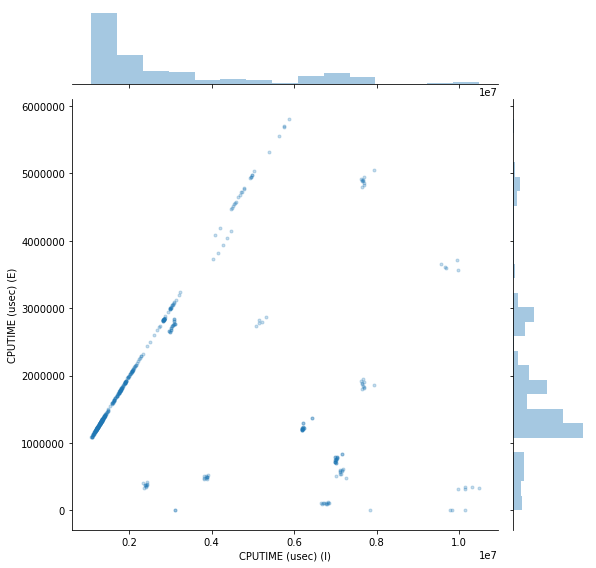

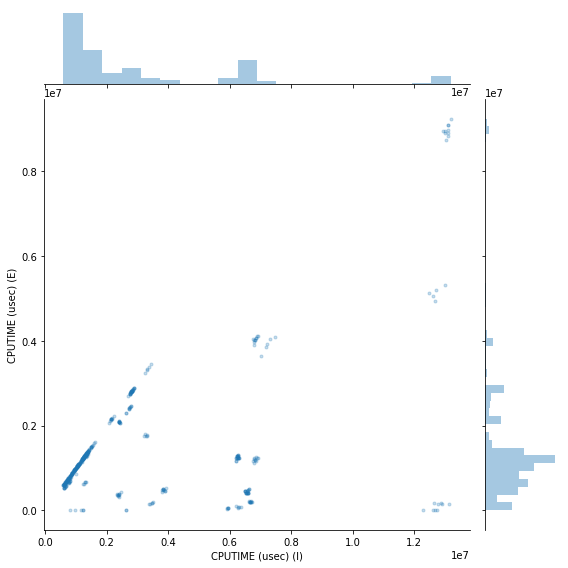

In [10]:
# Joint plot of the Inclusive and Exclusive times.
df = states[0].df
df2 = states[1].df
root_max_df = 107348942.00
root_max_df2 = 145114370.00
sns.jointplot('CPUTIME (usec) (I)', 'CPUTIME (usec) (E)',
              df.loc[(df['CPUTIME (usec) (I)'] < 0.10*107348942.00) &
                     (df['CPUTIME (usec) (E)'] > 0)],
              alpha=.25, marker='.', height=8);
sns.jointplot('CPUTIME (usec) (I)', 'CPUTIME (usec) (E)',
              df2.loc[(df2['CPUTIME (usec) (I)'] < 0.10*145114370.00) &
                     (df2['CPUTIME (usec) (E)'] > 0)],
              alpha=.25, marker='.', height=8);

In [11]:
def add_paths(state, path_name):
    for idx, row in state.df.iterrows():
        state.g.add_path(row[path_name])

In [12]:
def print_graph(states):
    for idx, state in enumerate(states):
        print(state.g.nodes())

In [21]:
def draw_graph(g):
    fig, ax = plt.subplots()
    plot_network(g, )
    plt.show()
    #pos = nx.spectral_layout(g)
    #nx.draw_networkx_nodes(g, pos, cmap=plt.get_cmap('jet'), 
    #                    node_size = 50)
    #nx.draw_networkx_edges(g, pos, edge_color='b', arrows=True)


In [14]:
def add_levels(state):
    levelMap = {}
    track_level = 0
    nodes = state.g.nbunch_iter(state.root)
    
    for start_node in nodes:
        print("Start node", start_node)
        active_nodes = [start_node]
        levelMap[state.root] = 0
        
        for edge in nx.edge_dfs(state.g, start_node, 'original'):
            #rint("Edge {0}".format(edge))
            head_level = None
            tail_level = None
            head, tail = edge[0], edge[1]
            
            if head != start_node:
                active_nodes.append(head)
                
            if head in active_nodes and head != start_node and tail in active_nodes:
                #rint("Cycle", edge)
                edge_data = state.g.get_edge_data(*edge)                                                                             
                state.g.add_node(tail+'_')                                                                                           
                state.g.add_edge(head, tail+'_', data=edge_data)                                                                     
                state.g.node[tail+'_']['name'] = [tail + '_']                                                                        
                #state.g.node[tail+'_']['weight'] = state.g.node[tail]['weight']   
                state.g.remove_edge(edge[0], edge[1])
    return levelMap

In [15]:
 def flow_map(state):                                                                                                                 
        flowMap = {}                                                                                                                    
        nodes = state.g.nbunch_iter(state.root)                                                                                           
        for start_node in nodes:                                                                                                        
            for edge in nx.edge_dfs(state.g, start_node, 'original'):                                                                    
                head_level = None                                                                                                       
                tail_level = None                                                                                                       
                head, tail = self.tailhead(edge)                                                                                        
                                                                                                                                        
                # Check if there is an existing level mapping for the head node and assign.                                             
                if head in self.level_mapping.keys():                                                                                   
                    head_level =  self.level_mapping[head]                                                                              
                                                                                                                                        
                # Check if there is an existing level mapping for the tail node and assign.                                             
                if tail in self.level_mapping.keys():                                                                                   
                    tail_level = self.level_mapping[tail]                                                                               
                                                                                                                                        
                flowMap[(edge[0], edge[1])] = (int(head_level), int(tail_level))                                                        
        return flowMap 

In [16]:
def calculate_flows(state):
    graph = state.g
    ret = {}                                                                                                                                                                                                                                                                          
    edges = graph.edges()                                                                                                                                                                                                                                                             
    additional_flow = {}                                                                                                                                                                                                                                                              
                                                                                                                                                                                                                                                                                          
    # Calculates the costs in cycles and aggregates to one node.                                                                                                                                                                                                                      
    for edge in edges:                                                                                                                                                                                                                                                                
        source = edge[0]                                                                                                                                                                                                                                                              
        target = edge[1]                                                                                                                                                                                                                                                              
                                                                                                                                                                                                                                                                                          
        if source.endswith('_'):                                                                                                                                                                                                                                                      
            cycle_node = source                                                                                                                                                                                                                                                       
            cycle_node_df = self.state.lookup_with_nodeName(cycle_node[:-1])                                                                                                                                                                                                      
            additional_flow[cycle_node] = cycle_node_df['CPUTIME (usec) (I)'].max()                                                                                                                                                                                                   
        elif target.endswith('_'):                                                                                                                                                                                                                                                    
            cycle_node = target                                                                                                                                                                                                                                                       
            cycle_node_df = state.lookup_with_nodeName(cycle_node[:-1])                                                                                                                                                                                                      
            additional_flow[cycle_node] = cycle_node_df['CPUTIME (usec) (I)'].max()                                                                                                                                                                                                   
                                                                                                                                                                                                                                                                                          
    for edge in edges:                                                                                                                                                                                                                                                                
        added_flow = 0                                                                                                                                                                                                                                                                
        if edge[0].endswith('_'):                                                                                                                                                                                                                                                     
            ret[edge] = additional_flow[edge[0]]                                                                                                                                                                                                                                      
            continue                                                                                                                                                                                                                                                                  
        elif edge[1].endswith('_'):                                                                                                                                                                                                                                                   
            ret[edge] = additional_flow[edge[1]]                                                                                                                                                                                                                                      
            continue                                                                                                                                                                                                                                                                  
        source = state.lookup_with_nodeName(edge[0])                                                                                                                                                                                                                         
        target = state.lookup_with_nodeName(edge[1])                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                          
        source_inc = source['CPUTIME (usec) (I)'].max()                                                                                                                                                                                                                               
        target_inc = target['CPUTIME (usec) (I)'].max()                                                                         
                                                                                                                                                                                                                                                                                          
        if source_inc == target_inc:                                                                                                                                                                                                                                                  
            ret[edge] = source_inc                                                                                                                                                                                                                                                    
        else:                                                                                                                                                                                                                                                                         
            ret[edge] = target_inc    
    return ret   

In [17]:
def add_edge_attributes(state):
    capacity_mapping = calculate_flows(state)    
    nx.set_edge_attributes(state.g, name='weight', values=capacity_mapping)

Start node <partial call paths>


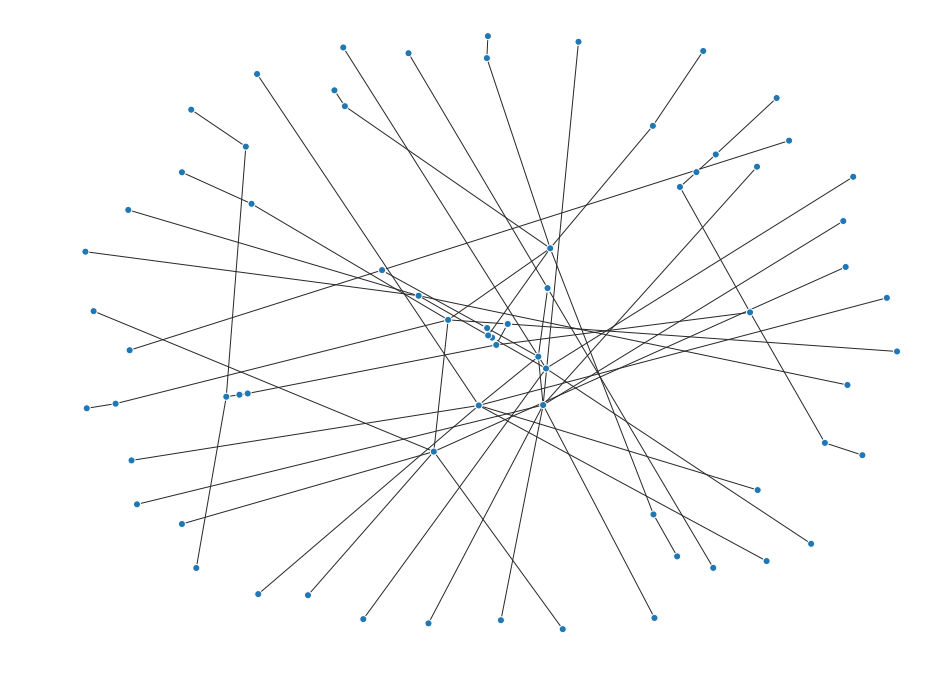

Start node <partial call paths>


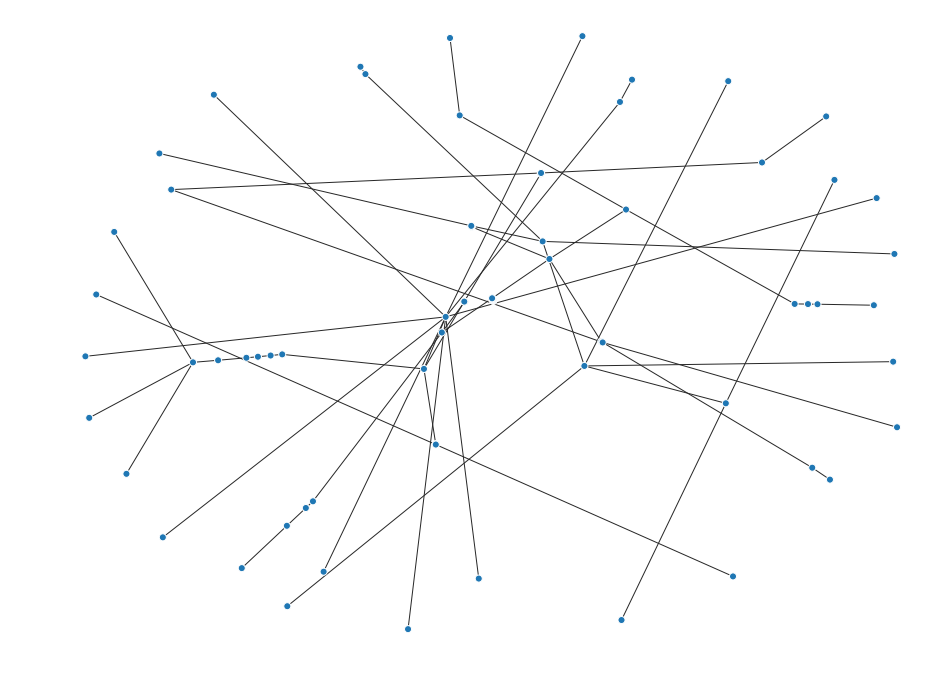

In [22]:
for idx, state in enumerate(states):
    state.g = nx.DiGraph()
    state.root = state.lookup_with_node(state.graph.roots[0])['name'][0]
    state.rootInc = state.lookup_with_node(state.graph.roots[0])['CPUTIME (usec) (I)'].max()
    add_paths(state, 'path')
    state.levelMap = add_levels(state)
    add_edge_attributes(state)  
    draw_graph(state.g)

In [ ]:
def create_flow_matrix(state):
    g = state.g
    nodes = g.nodes()
    
    state.nodeKey = {}
    for idx, node in enumerate(nodes):
        state.nodeKey[node] = idx
    
    flow_matrix = np.zeros(shape=(len(nodes),len(nodes)))
    flow_matrix.astype(float)
    
    for idx, node in enumerate(nodes):
        if idx == 0:
            neighbors = sorted(g[node].items(), key=lambda edge: edge[1]['weight'])
            for idx, n in enumerate(neighbors):
                sourceKey = int(state.nodeKey[node])
                targetKey = int(state.nodeKey[n[0]])
                weight = n[1]['weight']
                flow_matrix[sourceKey][targetKey] = n[1]['weight']/(1.0*state.rootInc)
    return flow_matrix

for idx, state in enumerate(states):
     state.flow_matrix = create_flow_matrix(state)

In [ ]:
xs = np.array([states[0].flow_matrix, states[1].flow_matrix])
print(xs)

In [ ]:
S = len(states)

ns = [len(xs[s]) for s in range(S)]
n_samples = 30

"""Compute all distances matrices for the four shapes"""
Cs = [sp.spatial.distance.cdist(xs[s], xs[s]) for s in range(S)]
Cs = [cs / cs.max() for cs in Cs]

print(Cs)
ps = [ot.unif(ns[s]) for s in range(S)]
p = ot.unif(n_samples)
print(ps)

lambdast = [[float(i) / 3, float(3 - i) / 3] for i in [1, 2]]

Ct01 = [0 for i in range(2)]
for i in range(S):
    Ct01[i] = ot.gromov.gromov_barycenters(n_samples, [Cs[0], Cs[1]],
                                           [ps[0], ps[1]
                                            ], p, lambdast[i], 'square_loss',  # 5e-4,
                                           max_iter=100, tol=1e-3)


plt.plot(Ct01[0], Ct01[1], 'o', label = 'Ct01')
plt.show()


In [ ]:
def smacof_mds(C, dim, max_iter=3000, eps=1e-9):
    """
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensionned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

    rng = np.random.RandomState(seed=3)

    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        n_init=1)
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=rng,
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)

    return npos

In [ ]:
clf = PCA(n_components=2)
npos = [0, 0]
npos = [smacof_mds(Cs[s], 2) for s in range(S)]

npost01 = [0, 0]
npost01 = [smacof_mds(Ct01[s], 2) for s in range(2)]
npost01 = [clf.fit_transform(npost01[s]) for s in range(2)] 

print(npost01)
plt.plot(npost01[0], npost01[1], 'o', label = 'npost01')
plt.show()

plt.plot(npos[0], npos[1], 'o', label = 'npos')
plt.show()

nx01min = npos[0][0][0]
nx01max = npos[0][0][0]
ny01min = npos[0][1][1]
ny01max = npos[0][1][1]

nx02min = npos[1][0][0]
nx02max = npos[1][0][0]
ny02min = npos[1][1][1]
ny02max = npos[1][1][1]

for idx, arr in enumerate(npos):
    if arr[0][0] < nx01min:
        nx01min = arr[0][0]
    else:
        pass
    
    if arr[0][1] > nx01max:
        nx01max = arr[0][1]
    else:
        pass
    
    if arr[1][0] < ny01min:
        ny01min = arr[1][0]
    else:
        pass
    
    if arr[1][1] > ny01max:
        ny01max = arr[1][1]
    else:
        pass


for idx, arr in enumerate(npost01):
    if arr[0][0] < nx02min:
        nx02min = arr[0][0]
    else:
        pass
    
    if arr[0][1] > nx02max:
        nx02max = arr[0][1]
    else:
        pass
    
    if arr[1][0] < ny02min:
        ny02min = arr[1][0]
    else:
        pass
    
    if arr[1][1] > ny02max:
        ny02max = arr[1][1]
    else:
        pass

fig = plt.figure(figsize=(10, 10))

x1 = []
y1 = []
for idx, val in enumerate(npost01[0]):
    x1.append(val[0])
    y1.append(val[1])
    
x2 = []
y2 = []
for idx, val in enumerate(npost01[1]):
    x2.append(val[0])
    y2.append(val[1])

x1 = np.asarray(x1)
x2 = np.asarray(x2)
y1 = np.asarray(y1)
y2 = np.asarray(y2)

x1min = np.minimum(x1)
x2min = np.minimum(x2)
x1max = np.maximum(x1)
x2max = np.maximum(x2)

y1min = np.minimum(y1)
y2min = np.minimum(y2)
y1max = np.maximum(y1)
y2max = np.maximum(y2)
#ax1 = plt.subplot2grid((1, 1), (0, 0))  
#plt.xlim((nx01min - 0.1, nx01max + 0.1))
#plt.ylim((ny01min - 0.1, ny01max + 0.1))
#ax1.scatter(npos[0][:, 0], npos[0][:, 1], color='r')

ax2 = plt.subplot2grid((1, 2), (0, 1))
plt.xlim(x1min, x1max)
plt.ylim(y1min, y1max)
ax2.scatter(x1, y1, color='b')
ax2.scatter(x2, y2, color='r')

print(x1, x2)
print(y1, y2)